GPU上での高速な物理シミュレーションは、(RLHFやOffline RLに押され気味とはいえ)強化学習界隈では話題のトピックですよね。また単純に、GPU上で爆速でシミュレーションが終わるのはなかなか楽しいものです。
[NVIDIA IsaacSym](https://docs.omniverse.nvidia.com/index.html)もありますが、jaxで強化学習パイプライン全体を高速化したいなら[brax](https://github.com/google/brax)が便利です。以前[紹介するブログ](https://kngwyu.github.io/rlog2/posts/jax-brax-haiku.html)も書きましたが、現在のバージョンではより精度のいい手法が選べるようになっていて、普通にMuJoCoの代わりに使えそうな感じです。しかし、最近単純な2次元物理シミュレーションでbraxが使えないかな？と思って検討してみたところ、無理ではないのだけれどどうにも使いづらいな...という印象でした。また、二次元物理シミュレーションをするのに、三次元のボールとかで当たり判定を行うのはちょっと計算資源がもったいない気もします。なら自分で作ってしまえばいいんじゃないか？ということでやってみました。

# Semi-implicit Eulerで物体を動かす

とりあえず、衝突のことはいったん忘れて、物体を動かしてみましょう。物体の位置・速度を$x, v$、その時間微分を$\dot{x} = \frac{dx}{dt}, \dot{v} = \frac{dv}{dt}$とおきます。ニュートンの運動の第二法則から、$F(t) = m \frac{d^2 x}{dt^2}(t)$ですから、最も単純な速度・位置更新の近似は、適当な十分短い時間間隔$\Delta t$をとって、

$$
\dot{x}_{t + 1} = \dot{v}_t \Delta t \\
\dot{v}_{t + 1} = \frac{F}{m} \Delta t
$$

と表せます（Explicit Euler)。これは不安定になるので、今回は安定しやすい[Semi-implicit Euler](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method)を使います。これはアルゴリズム上はすごく単純で、

$$
\dot{v}_{t + 1} = \frac{F}{m} \Delta t \\
\dot{x}_{t + 1} = \dot{v}_{t + 1} \Delta t
$$

とすればいいです。


まず`Velocity`など、必要なものを適当に定義しておきます。剛体ですが、とりあえずこの世界には丸いものしかないことにして、`Circle`だけ定義しましょう。

In [1]:
from typing import Any, Sequence

import chex
import jax
import jax.numpy as jnp

Self = Any


class PyTreeOps:
    def __add__(self, o: Any) -> Self:
        if o.__class__ is self.__class__:
            return jax.tree_map(lambda x, y: x + y, self, o)
        else:
            return jax.tree_map(lambda x: x + o, self)

    def __sub__(self, o: Any) -> Self:
        if o.__class__ is self.__class__:
            return jax.tree_map(lambda x, y: x - y, self, o)
        else:
            return jax.tree_map(lambda x: x - o, self)

    def __mul__(self, o: float | jax.Array) -> Self:
        return jax.tree_map(lambda x: x * o, self)

    def __neg__(self) -> Self:
        return jax.tree_map(lambda x: -x, self)

    def __truediv__(self, o: float | jax.Array) -> Self:
        return jax.tree_map(lambda x: x / o, self)
    
    def expand_dims(self, axis: int | None = None) -> Any:
        return jax.tree_map(lambda x: jnp.expand_dims(x, axis=axis), self)
    
    def get_slice(self, index: int | Sequence[int] | Sequence[bool]) -> Self:
        return jax.tree_map(lambda x: x[index], self)

    def reshape(self, shape: Sequence[int]) -> Self:
        return jax.tree_map(lambda x: x.reshape(shape), self)

    def tolist(self) -> list[Self]:
        leaves, treedef = jax.tree_util.tree_flatten(self)
        return [treedef.unflatten(leaf) for leaf in zip(*leaves)]

    def zeros_like(self) -> Any:
        return jax.tree_map(lambda x: jnp.zeros_like(x), self)


TWO_PI = jnp.pi * 2


@chex.dataclass
class Velocity(PyTreeOps):
    angle: jax.Array  # Angular velocity (N, 1)
    xy: jax.Array  # (N, 2)


@chex.dataclass
class Force(PyTreeOps):
    angle: jax.Array  # Angular (torque) force (N, 1)
    xy: jax.Array  # (N, 2)


@chex.dataclass
class Position(PyTreeOps):
    angle: jax.Array  # Angular velocity (N, 1)
    xy: jax.Array  # (N, 2)
    
    
@chex.dataclass
class Shape(PyTreeOps):
    mass: jax.Array
    moment: jax.Array
    elasticity: jax.Array
    friction: jax.Array
    rgba: jax.Array
    
    def as_shape(self) -> Any:
        return Shape(
            mass=self.mass,
            moment=self.moment,
            elasticity=self.elasticity,
            friction=self.friction,
            rgba=self.rgba,
        )


@chex.dataclass
class Circle(Shape):
    radius: jax.Array


@chex.dataclass
class State(PyTreeOps):
    p: Position
    v: Velocity
    f: Force


@chex.dataclass
class Space:
    gravity: jax.Array
    circle: Circle
    dt: jax.Array | float = 0.1
    damping: jax.Array | float = 0.9
    bias_factor: jax.Array | float = 0.2
    allowed_penetration: jax.Array | float = 0.005

    @property
    def mass(self) -> jax.Array:
        return self.circle.mass.reshape(-1, 1)
    
    @property
    def moment(self) -> jax.Array:
        return self.circle.moment

次は描画用の関数を準備しましょう。

In [2]:
from typing import Iterable

from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.patches import Circle as CirclePatch


def visualize_balls(ax: Axes, circles: Circle, positions: Iterable[Position]) -> None:
    pos = list(positions)
    circle_list = circles.tolist()
    for pi in pos:
        for pij, circle in zip(pi.tolist(), circle_list):
            circle_patch = CirclePatch(
                xy=pij.xy,
                radius=circle.radius,
                fill=False,
                color=circle.rgba.tolist(),
            )
            ax.add_patch(circle_patch)

Semi-implicit Eulerを実装します。

In [3]:
def update_velocity(space: Space, state: State) -> State:
    damped = state.v * space.damping
    v_xy = damped.xy + (space.gravity + state.f.xy / space.mass) * space.dt
    v_ang = damped.angle + state.f.angle / space.moment * space.dt
    return state.replace(v=Velocity(angle=v_ang, xy=v_xy), f=state.f.zeros_like())

def update_position(space: Space, state: State) -> State:
    v_dt = state.v * space.dt
    xy = state.p.xy + v_dt.xy
    angle = (state.p.angle + v_dt.angle + TWO_PI) % TWO_PI
    return state.replace(p=Position(angle=angle, xy=xy))

とりあえずボールを落としてみましょう。

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


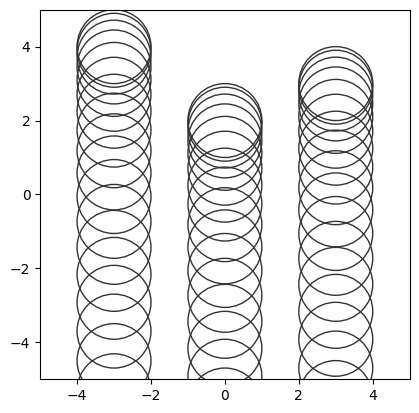

In [4]:
circles = Circle(
    mass=jnp.ones(3),
    radius=jnp.ones(3),
    moment=jnp.ones(3) * 0.5,
    elasticity=jnp.ones(3),
    friction=jnp.ones(3),
    rgba=jnp.tile(jnp.array([0.2, 0.2, 0.2, 1.0]), (3, 1)),
)
space = Space(gravity=jnp.array([0.0, -9.8]), circle=circles)
p = Position(
    angle=jnp.array([-2, 0.1, 0.2]),
    xy=jnp.array([[-3, 4.0], [0.0, 2.0], [3.0, 3]]),
)
v = Velocity(angle=jnp.zeros(3), xy=jnp.zeros((3, 2)))
f = Force(angle=jnp.zeros(3), xy=jnp.zeros((3, 2)))
state = State(p=p, v=v, f=f)
positions = [state.p]
for i in range(20):
    state = update_velocity(space, state)
    state = update_position(space, state)
    positions.append(state.p)
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
visualize_balls(ax, space.circle, positions)

できたっぽいですね。

## 衝突判定を行う

次に衝突判定を実装してみましょう。円と円しかないので判定自体は簡単ですが、後で衝突後の物理状態を求めるために計算するときのため、衝突した場所やそれによって発生したインパルスといった情報を保存しておく必要があります。
また、衝突判定を行う際、全てのペアについて衝突を検出するコードをナイーブに書くと、以下のようになります。
```python
for i in range(N):
    for j in range(i + 1, N):
        check_contact(i, j)
```
ですが、衝突検出は各ペアについて独立に行えるので、`jax.vmap`を使って並列化したいところです。そこで、このループを手動でアンロールし、あらかじめペアを生成してから`vmap`で並列化した衝突検出関数を呼ぶようにしました。以下のコード中の`generate_all_pairs`が全ペアを生成する関数になります。

In [5]:
from typing import Any, Callable

from jax import tree_util as jtu

Axis = Sequence[int] | int


def safe_norm(x: jax.Array, axis: Axis | None = None) -> jax.Array:
    is_zero = jnp.allclose(x, 0.0)
    x = jnp.where(is_zero, jnp.ones_like(x), x)
    n = jnp.linalg.norm(x, axis=axis)
    return jnp.where(is_zero, 0.0, n)  # pyright: ignore


def normalize(x: jax.Array, axis: Axis | None = None) -> tuple[jax.Array, jax.Array]:
    norm = safe_norm(x, axis=axis)
    n = x / (norm + 1e-6 * (norm == 0.0))
    return n, norm


def tree_map2(
    f: Callable[..., Any],
    tree: Any,
    *rest: Any,
    is_leaf: Callable[[Any], bool] | None = None
) -> tuple[Any, Any]:
    """Same as tree_map, but returns a tuple"""
    leaves, treedef = jtu.tree_flatten(tree, is_leaf)
    all_leaves = [leaves] + [treedef.flatten_up_to(r) for r in rest]
    result = [f(*xs) for xs in zip(*all_leaves)]
    a = treedef.unflatten([elem[0] for elem in result])
    b = treedef.unflatten([elem[1] for elem in result])
    return a, b


def generate_all_pairs(x: jax.Array) -> tuple[jax.Array, jax.Array]:
    """Returns two arrays that iterate over all combination of elements in x."""
    # x.shape[0] > 1
    chex.assert_axis_dimension_gt(x, 0, 1)
    n = x.shape[0]
    # (a, a, a, b, b, c)
    outer_loop = jnp.repeat(
        x,
        jnp.arange(n - 1, -1, -1),
        axis=0,
        total_repeat_length=n * (n - 1) // 2,
    )
    # (b, c, d, c, d, d)
    inner_loop = jnp.concatenate([x[i:] for i in range(1, len(x))])
    return outer_loop, inner_loop


@chex.dataclass
class Contact(PyTreeOps):
    r1: jax.Array
    r2: jax.Array
    pos: jax.Array
    normal: jax.Array
    penetration: jax.Array
    elasticity: jax.Array
    friction: jax.Array


def circle_to_circle(a: Circle, b: Circle, a_pos: Position, b_pos: Position) -> Contact:
    b2a_normal, dist = normalize(a_pos.xy - b_pos.xy)
    penetration = a.radius + b.radius - dist
    a_contact = a_pos.xy - b2a_normal * a.radius
    b_contact = b_pos.xy + b2a_normal * b.radius
    pos = (a_contact + b_contact) * 0.5
    contact = Contact(
        r1=pos - a_pos.xy,
        r2=pos - b_pos.xy,
        pos=pos,
        normal=b2a_normal,
        penetration=penetration,
        elasticity=(a.elasticity + b.elasticity) * 0.5,
        friction=(a.friction + b.friction) * 0.5,
    )
    # Expand the dimension to (1, x) for compatibility
    return contact.expand_dims(axis=0)


def check_c2c_contacts(
    space: Space,
    position: Position,
) -> tuple[Contact, Circle, Circle]:
    circle1, circle2 = tree_map2(generate_all_pairs, space.circle)
    pos1, pos2 = tree_map2(generate_all_pairs, position)
    contacts = jax.vmap(circle_to_circle)(circle1, circle2, pos1, pos2)
    return contacts, circle1, circle2

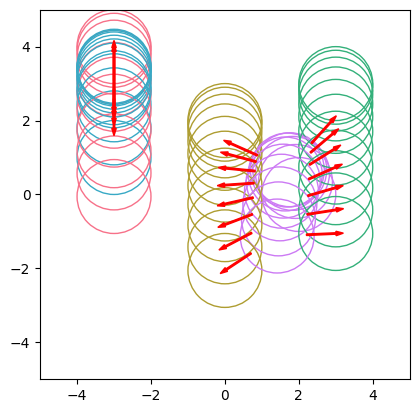

In [6]:
import seaborn as sns
from matplotlib.patches import Arrow

N = 5
palette = sns.color_palette("husl", N)


circles = Circle(
    mass=jnp.ones(N),
    radius=jnp.ones(N),
    moment=jnp.ones(N) * 0.5,
    elasticity=jnp.ones(N),
    friction=jnp.ones(N),
    rgba=jnp.array([p + (1.0,) for p in palette]),
)
space = Space(gravity=jnp.array([0.0, -9.8]), circle=circles)
p = Position(
    angle=jnp.zeros(N),
    xy=jnp.array([[-3, 4.0], [0.0, 2.0], [3.0, 3], [-3, 1], [2, 0]]),
)
v_xy = jnp.concatenate((jnp.zeros((N - 2, 2)), jnp.array([[0, 10.0], [-1.0, 5.0]])))
v = Velocity(angle=jnp.zeros(N), xy=v_xy)
f = Force(angle=jnp.zeros(N), xy=jnp.zeros((N, 2)))
state = State(p=p, v=v, f=f)
positions = [state.p]
contact_list = []
for i in range(10):
    state = update_velocity(space, state)
    state = update_position(space, state)
    positions.append(state.p)
    contacts, _, _ = check_c2c_contacts(space, state.p)
    total_index = 0
    for j in range(N):
        for k in range(j + 1, N):
            if contacts.penetration[total_index, 0] > 0:
                contact_list.append(contacts.get_slice((total_index, 0)))
            total_index += 1
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
visualize_balls(ax, space.circle, positions)
for contact in contact_list:
    arrow = Arrow(*contact.pos, *contact.normal, width=0.2, color="r")
    ax.add_patch(arrow)

衝突後の処理を実装していないので物体がすりぬけていますが、衝突自体はきちんと検出されているようです。

## 衝突した後どうすればいいの

衝突を検出した後は、物体が重ならないように衝突時に発生したインパルスに関する制約つき方程式を解く必要があります。そのために色々な方法があるのですが、今回は[Chipmunk](https://github.com/slembcke/Chipmunk2D)など2次元物理エンジンでよく使われている[Sequential Impulse](https://box2d.org/files/ErinCatto_SequentialImpulses_GDC2006.pdf)と呼ばれる方法を使ってみます。なお、この資料は[Box2D](https://box2d.org)のWebページで公開されているものですが、Box2D自体は[Gauss-Seidel](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method)ソルバーを使っています。

では、Sequential Impulseではどのようにして衝突を解決するのでしょうか。まず、物体の衝突時にインパルスが発生するという衝突モデルを仮定し、発生したインパルスを$\mathbf{p}$とおきます。面倒なので角速度は一切考えないことにします。このとき、物体1の速度を$\mathbf{v}_1$、質量を$m_1$、物体2の速度を$\mathbf{v}_2$、質量を$m_2$とおくと、インパルスが発生した後の速度は
$$
\begin{align*}
\mathbf{v}_1 = \mathbf{v}_1^{\mathrm{old}} - \mathbf{p} / m_1 \\
\mathbf{v}_2 = \mathbf{v}_2^{\mathrm{old}} + \mathbf{p} / m_2
\end{align*}
$$
となります。このとき、$\mathbf{p}$の方向は衝突の法線ベクトル$\mathbf{n}$なので$\mathbf{p} = p\mathbf{n}$と表せます。よって、結局$p$を求めればいいです。衝突した点における相対速度を$\Delta \mathbf{v} = \mathbf{v}_2 - \mathbf{v}_1$とおきます。このとき、$\Delta \mathbf{v} \cdot n = 0$なので、上の2式と合わせて、$p = \frac{-\Delta \mathbf{v}^{\mathrm{old}}\cdot \mathbf{n}}{\frac{1}{m_1} + \frac{1}{m_2}}$となります。これに、更にめり込みを回避するためのバイアス速度$v_\mathrm{bias} = \frac{\beta}{\Delta t}\max(0, \delta - \delta_\mathrm{slop})$($\delta$はめりこみの長さ、$\delta_\mathrm{slop}$は許容されるめりこみの長さ)を使って$p = \frac{-\Delta \mathbf{v}^{\mathrm{old}}\cdot \mathbf{n} + v_\mathrm{bias}}{\frac{1}{m_1} + \frac{1}{m_2}}$とするのが一般的なようです。角速度や摩擦を考慮するともう少しややこしくなりますが、基本はこんな感じです。

こうして計算したインパルスを全ての衝突に対して適用します。ただ、これだけだとまた別のめりこみが発生している可能性があるので、何度か繰り返す必要があります。この方法だとめりこみが完全に解消される保証はないので、絶対にめりこみが発生してほしくない場合はPosition Based DynamicsやMuJoCoで採用しているSoft Contact Modelなど別の方法を使ったほうがいいです。というわけでSequential Impulseを実装してみましょう。

また、さっき並列化のため手動で全ペアに対するループをアンロールしましたが、Sequential Impulseの実装でもこれが使えます。ただし、インパルスを加えた後の速度の更新は、`v_update[i][j]`に`i`番目の物体と`j`番目の物体の衝突により生じる`i`番目の物体の速度変化が入っているとして、
```python
for i in range(N):
    for j in range(i + 1, N):
        obj[i].velocity += v_update[i][j]
        obj[j].velocity += v_update[j][i]
```
のように各衝突により生じた速度変化を物体にフィードバックする必要があります。これもいちいちループで書くと遅くなってしまうのですが、さっきの`generate_all_pairs`と[`jax.numpy.bincount`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.bincount.html)を組み合わせるとうまいことループなしで書けます。もっと正確にいうと、`generate_all_pairs`ではループが使われているのですが、ループの結果が`jax.jit`でコンパイルした時に定数になるはず(確認してないけど...)なので気にしなくてもいいです。

In [10]:
@chex.dataclass
class ContactHelper(PyTreeOps):
    tangent: jax.Array
    mass_normal: jax.Array
    mass_tangent: jax.Array
    v_bias: jax.Array
    inv_mass1: jax.Array
    inv_mass2: jax.Array
    inv_moment1: jax.Array
    inv_moment2: jax.Array


@chex.dataclass
class ContactSolver(PyTreeOps):
    v: Velocity
    pn: jax.Array
    pt: jax.Array

    def v_pairs(self) -> tuple[Velocity, Velocity]:
        v1_angle, v2_angle = generate_all_paris(self.v.angle)
        v1_xy, v2_xy = generate_all_pairs(self.v.xy)
        return Velocity(angle=v1_angle, xy=v1.xy), Velocity(angle=v2_angle, xy=v2.xy)


def v_gather_update(old_v: Velocity, v1: Velocity, v2: Velocity) -> Velocity:
    indices = jnp.arange(len(old_v.angle))
    outer, inner = generate_all_pairs(indices)
    v1_xy = jnp.zeros_like(old_v.xy).at[outer].add(v1.xy)
    v1_angle = jnp.zeros_like(old_v.angle).at[outer].add(v1.angle)
    v2_xy = jnp.zeros_like(old_v.xy).at[inner].add(v2.xy)
    v2_angle = jnp.zeros_like(old_v.angle).at[inner].add(v2.angle)
    update = Velocity(xy=v1_xy, angle=v1_angle) + Velocity(xy=v2_xy, angle=v2_angle)
    return old_v + update


def _invm(shape: Shape, r: jax.Array, n: jax.Array) -> jax.Array:
    return 1.0 / shape.mass + 1.0 / shape.moment * jnp.cross(r, n) ** 2


def init_contact_helper(
    space: Space,
    contact: Contact,
    a: Shape,
    b: Shape,
) -> ContactHelper:
    normal = contact.normal
    k_normal = _invm(a, contact.r2, normal) + _invm(b, contact.r2, normal)
    tangent = jnp.dot(normal, jnp.array([[0, -1], [1, 0]], dtype=normal.dtype))
    k_tangent = _invm(a, contact.r1, tangent) + _invm(b, contact.r2, tangent)
    v_bias = (
        space.bias_factor
        / space.dt
        * jnp.clip(contact.penetration - space.allowed_penetration, a_min=0.0)
    )
    return ContactHelper(
        tangent=tangent,
        mass_normal=1 / k_normal,
        mass_tangent=1 / k_tangent,
        v_bias=v_bias,
        inv_mass1=1 / a.mass,
        inv_mass2=1 / b.mass,
        inv_moment1=1 / a.moment,
        inv_moment2=1 / b.moment,
    )


def _dv_from2to1(v1: Velocity, r1: jax.Array, v2: Velocity, r2: jax.Array) -> jax.Array:
    rel_v1 = v1.xy + jnp.cross(v1.angle, r1)
    rel_v2 = v2.xy + jnp.cross(v2.angle, r2)
    return rel_v1 - rel_v2


def step_solver(
    contact: Contact,
    helper: ContactHelper,
    solver: ContactSolver,
) -> ContactSolver:
    v1, v2 = solver.v_pairs()
    # Relative veclocity (from shape2 to shape1)
    dv = _dv_from2to1(v1, contact.r1, v2, contact.r2)
    vn = jnp.dot(dv, contact.normal)
    # Impulse
    dpn = helper.mass_normal * (vn - helper.v_bias)
    # Accumulate and clamp impulse
    pn = jnp.clip(solver.pn + dp, amin=0.0)
    dpn_clamped = contact.normal * (pn - solver.pn)
    # Velocity update by contact normal
    dvn1 = Velocity(
        angle=helper.inv_moment1 * jnp.cross(contact.r1, dpn_clamped),
        xy=helper.inv_mass1 * dpn_clamped,
    )
    dvn2 = Velocity(
        angle=-helper.inv_moment2 * jnp.cross(contact.r2, dpn_clamped),
        xy=-helper.inv_mass2 * dpn_clamped,
    )
    # Compute Relative velocity again
    dv = _dv_from2to1(v1 + dvn1, contact.r1, v2 + dvn2, contact.r2)
    vt = jnp.dot(dv, helper.tangent)
    dpt = -helper.mass_tangent * vt
    # Clamp friction impulse
    max_pt = contact.friction * pn
    pt = jnp.clip(solver.pt + dpt, a_min=-max_pt, a_max=max_pt)
    dpt_clamped = helper.tangent * (pt - solver.pt)
    # Velocity update by contact tangent
    dvt1 = Velocity(
        angle=helper.inv_moment1 * jnp.cross(contact.r1, dpt_clamped),
        xy=helper.inv_mass1 * dpt_clamped,
    )
    dvt2 = Velocity(
        angle=-helper.inv_moment2 * jnp.cross(contact.r2, dpt_clamped),
        xy=-helper.inv_mass2 * dpt_clamped,
    )
    v = v_gather_update(solver.v, dvn1 + dvt1, dvn2 + dvt2)
    return ContactSolver(v=v, pn=pn, pt=pt)


def apply_seq_impulses(
    space: Space,
    v: Velocity,
    contact: Contact,
    a: Shape,
    b: Shape,
):
    helper = init_contact_helper(space, contact, a, b)
    n = len(v.angle)
    solver = ContactSolver(
        v=v,
        pn=jnp.zeros((n * (n - 1) // 2,)),
        pt=jnp.zeros((n * (n - 1) // 2,)),
    )

    def step(carried: tuple[jax.Array, ContactSolver]) -> tuple[jax.Array, ContactSolver]:
        n_iter, solver_i = carried
        solver_i1 = step_solver(contact, helper, solver_i)
        return n_iter + 1, solver_i1
    
    def stop(carried: tuple[jax.Array, ContactSolver]) -> bool:
        pass

In [11]:
contacts, c1, c2 = check_c2c_contacts(space, state.p)

In [12]:
helper = init_contact_helper(space, contacts, c1, c2)

In [43]:
indices = jnp.arange(N)
a, b = generate_all_pairs(indices)

In [57]:
v1 = jax.random.uniform(jax.random.PRNGKey(3), (len(a), 2))

In [58]:
v2 = jax.random.uniform(jax.random.PRNGKey(4), (len(b), 2))

In [59]:
v1, v2

(Array([[0.44545305, 0.7178887 ],
        [0.96977115, 0.18764281],
        [0.8887385 , 0.41632903],
        [0.4198712 , 0.21385932],
        [0.77880204, 0.8877921 ],
        [0.8073578 , 0.3385303 ],
        [0.7948718 , 0.65629005],
        [0.21314299, 0.70475256],
        [0.89879644, 0.96618116],
        [0.06064963, 0.10369527]], dtype=float32),
 Array([[0.57027197, 0.05251229],
        [0.15699697, 0.19142318],
        [0.9153528 , 0.9551662 ],
        [0.8592236 , 0.01331699],
        [0.29227567, 0.17368269],
        [0.91099644, 0.58356094],
        [0.54236174, 0.8270277 ],
        [0.42894685, 0.6003355 ],
        [0.7292664 , 0.34254766],
        [0.52089894, 0.22382486]], dtype=float32))

In [67]:
jnp.zeros((5, 2)).at[a].add(v1) + jnp.zeros((5, 2)).at[b].add(v2)

Array([[2.723834 , 1.5357199],
       [2.9513035, 1.9351248],
       [1.5612121, 2.0360396],
       [2.3159459, 2.2427578],
       [2.6517506, 1.4067172]], dtype=float32)

In [66]:
gathered = [jnp.zeros(2)] * 5
global_index = 0
for i in range(N):
    for j in range(i + 1, N):
        gathered[i] += v1[global_index]
        gathered[j] += v2[global_index]
        global_index += 1
gathered

[Array([2.723834 , 1.5357199], dtype=float32),
 Array([2.9513035, 1.9351248], dtype=float32),
 Array([1.5612121, 2.0360396], dtype=float32),
 Array([2.3159459, 2.2427578], dtype=float32),
 Array([2.6517506, 1.4067172], dtype=float32)]

In [49]:
jnp.bincount(a, v1, length=5)

Array([1.769526  , 1.4073604 , 1.0450029 , 0.08007634, 0.        ],      dtype=float32)

In [50]:
v1[0] + v1[1] + v1[2] + v1[3]

Array(1.769526, dtype=float32)

In [52]:
a

Array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3], dtype=int32)

In [53]:
b

Array([1, 2, 3, 4, 2, 3, 4, 3, 4, 4], dtype=int32)